# SVM

## Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Import Dataset

In [6]:
DATASET_PATH = "../data/output/tfidf_dataset.csv"
RNG = 42  # Random seed

df = pd.read_csv(DATASET_PATH)

print(df['cyberbullying'].value_counts())
df.head(10)

cyberbullying
0    16225
1    16225
Name: count, dtype: int64


,10th,12th,15th,16th,1960s,19th,19th century,1px,1px solid,1st,...,zealand,zero,zionist,zoe,zone,zoo,zuck,zuckerberg,ŷour,cyberbullying
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Perform 80-20 split of data

In [12]:
# 1. Separate features and labels
X = df.drop(columns=['cyberbullying'])  # TF-IDF features
y = df['cyberbullying']                 # Target label

# Split into 80% train, 20% test (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RNG
)

## Fitting

In [ ]:
K = 5 # Number of folds for k-fold CV

# 2. Initialize model and parameter grid (varying C)
svm = LinearSVC(random_state=RNG, max_iter=5000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# 3. Set up cross-validation strategy on TRAINING set (5-fold for acceptable bias-variance tradeoff)
# Specifically, evaluate on out of fold predictions (Just one prediction per sample, 
# made by a model trained samples from all other folds.)
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=RNG)

# 4. Run grid search to determine the best value for C
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1_macro',  # Choose 'f1_macro' for balanced class evaluation
    cv=cv,
    n_jobs=3            # Use 6 cores
)
grid_search.fit(X_train, y_train)

# 5. Retrieve and display the best model
best_model = grid_search.best_estimator_
print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best F1 (macro): {grid_search.best_score_:.4f}")
print()

# 6. Predict on the TEST set (previously untouched 20%) using the best model
y_pred = best_model.predict(X_test)

Best C value: 1
Best F1 (macro): 0.8916



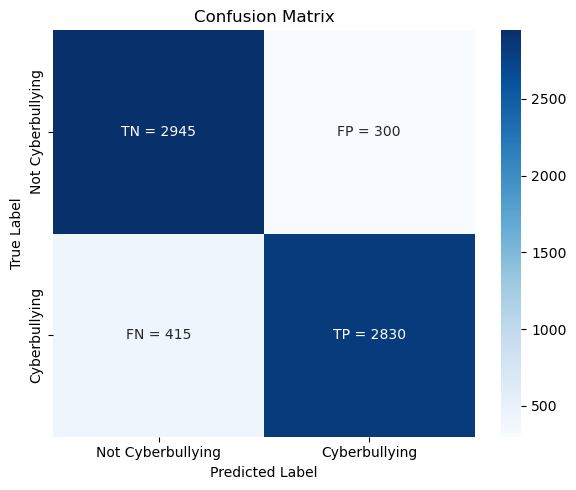

In [ ]:
# 7. Display performance metrics

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Cyberbullying', 'Cyberbullying']

# Annotate with TP, TN, FP, FN
annot_labels = [
    [f"TN = {cm[0,0]}", f"FP = {cm[0,1]}"],
    [f"FN = {cm[1,0]}", f"TP = {cm[1,1]}"]
]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Display the Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=labels))

## Feature Extraction and Visualization

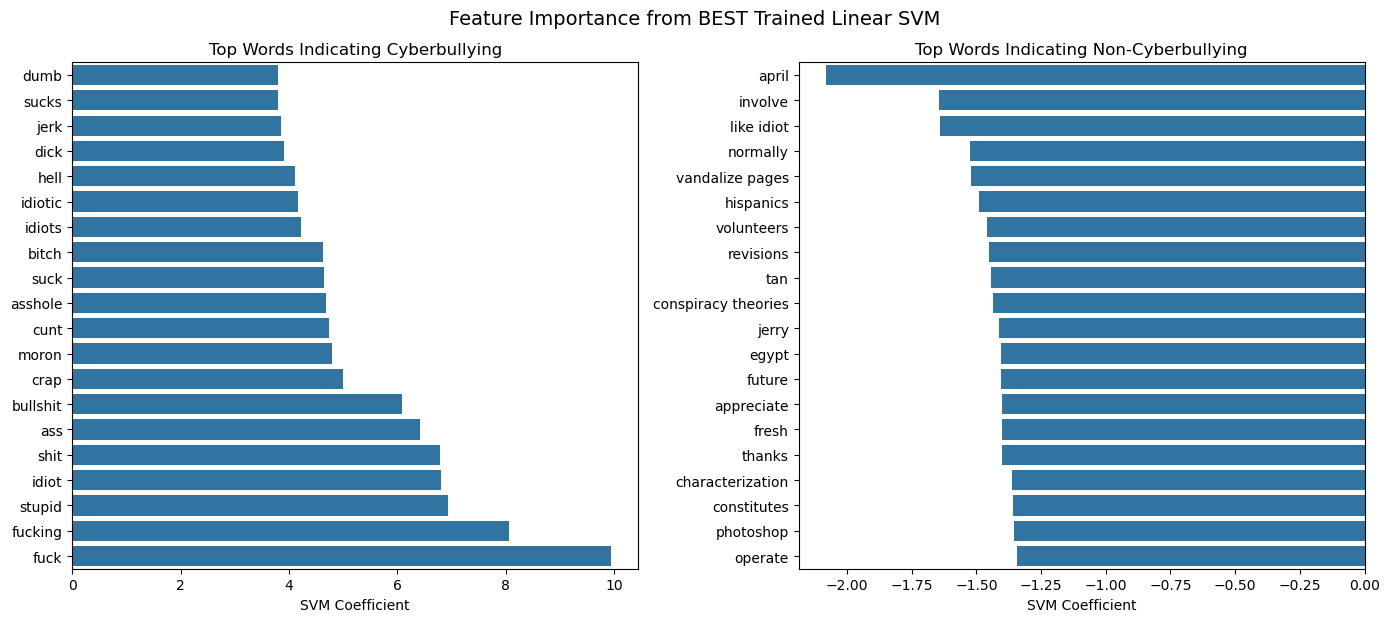

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients
coefs = best_model.coef_.flatten()
feature_names = X.columns.to_numpy()

# Identify top features for both classes
top_n = 20
top_pos_idx = np.argsort(coefs)[-top_n:]
top_neg_idx = np.argsort(coefs)[:top_n]

# Plot
plt.figure(figsize=(14, 6))

# Top features indicating cyberbullying (positive class)
plt.subplot(1, 2, 1)
sns.barplot(x=coefs[top_pos_idx], y=feature_names[top_pos_idx])
plt.title("Top Words Indicating Cyberbullying")
plt.xlabel("SVM Coefficient")
plt.tight_layout()

# Top features indicating non-cyberbullying (negative class)
plt.subplot(1, 2, 2)
sns.barplot(x=coefs[top_neg_idx], y=feature_names[top_neg_idx])
plt.title("Top Words Indicating Non-Cyberbullying")
plt.xlabel("SVM Coefficient")
plt.tight_layout()

plt.suptitle("Feature Importance from BEST Trained Linear SVM", fontsize=14, y=1.03)
plt.show()